In [3]:
import torch
from reconstruction import AE
from datasets import MeshData
from utils import utils, DataLoader, mesh_sampling, sap
import numpy as np
import pyvista as pv
from skimage import measure
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
from IPython.display import display
import meshplot as mp
import os, sys
from math import ceil
from scipy.ndimage import zoom
import open3d as o3d

In [4]:
# Meshplot left an annoying print statement in their code. Using this context manager to supress it...
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [5]:
device = torch.device('cuda', 0)
# Set the path to the saved model directory
#model_path = "/home/jakaria/torus_bump_500_three_scale_binary_bump_variable_noise_fixed_angle/models_classification_regression_contrastive_loss_only/models/199"
model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/models/5"
# Load the saved model
model_state_dict = torch.load(f"{model_path}/model_state_dict.pt")
in_channels = torch.load(f"{model_path}/in_channels.pt")
out_channels = torch.load(f"{model_path}/out_channels.pt")
latent_channels = torch.load(f"{model_path}/latent_channels.pt")
spiral_indices_list = torch.load(f"{model_path}/spiral_indices_list.pt")
up_transform_list = torch.load(f"{model_path}/up_transform_list.pt")
down_transform_list = torch.load(f"{model_path}/down_transform_list.pt")
std = torch.load(f"{model_path}/std.pt")
mean = torch.load(f"{model_path}/mean.pt")
template_face = torch.load(f"{model_path}/faces.pt")

# Create an instance of the model
model = AE(in_channels, out_channels, latent_channels,
           spiral_indices_list, down_transform_list,
           up_transform_list)
model.load_state_dict(model_state_dict)
model.to(device)
# Set the model to evaluation mode
model.eval()

AE(
  (en_layers): ModuleList(
    (0): SpiralEnblock(
      (conv): SpiralConv(3, 32, seq_length=9)
    )
    (1-2): 2 x SpiralEnblock(
      (conv): SpiralConv(32, 32, seq_length=9)
    )
    (3): SpiralEnblock(
      (conv): SpiralConv(32, 64, seq_length=9)
    )
    (4): Linear(in_features=11392, out_features=24, bias=True)
  )
  (de_layers): ModuleList(
    (0): Linear(in_features=12, out_features=11392, bias=True)
    (1): SpiralDeblock(
      (conv): SpiralConv(64, 64, seq_length=9)
    )
    (2): SpiralDeblock(
      (conv): SpiralConv(64, 32, seq_length=9)
    )
    (3-4): 2 x SpiralDeblock(
      (conv): SpiralConv(32, 32, seq_length=9)
    )
    (5): SpiralConv(32, 3, seq_length=9)
  )
  (cls_sq): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): Batc

In [6]:
rotation_matrix = np.array([[np.cos(np.pi), -np.sin(np.pi), 0],
                            [np.sin(np.pi), np.cos(np.pi), 0],
                            [0, 0, 1]]) #z axic
z = torch.zeros(12)
plot=None
@mp.interact(**{f'z[{i}]': FloatSlider(min=-1, max=1, step=0.2, value=0) for i in range(12)})
def show(**kwargs):
    global plot
    global z
    z = torch.tensor([kwargs[f'z[{i}]'] for i in range(12)])
    with torch.no_grad():
        z = z.to(device)
        #print(z)
        pred = model.decoder(z)

        reshaped_pred = (pred.view(-1, 3).cpu() * std) + mean
        reshaped_pred = reshaped_pred.cpu().numpy()
        print(reshaped_pred.shape)

    verts = reshaped_pred
    #verts = o3d.utility.Vector3dVector(np.dot(np.asarray(verts), rotation_matrix.T))
    verts = np.dot(np.asarray(verts), rotation_matrix.T)

    pcd = o3d.io.read_triangle_mesh('/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/template/template.ply')
    faces = np.asarray(pcd.triangles)
    #print(verts)
    #print(faces)

    # Define a threshold for separating the objects based on x-values
    x_threshold = 0.0

    # Separate vertices and faces for the first object (x < x_threshold)
    verts_object1 = verts[verts[:, 0] < x_threshold]
    faces_object1 = [face for face in faces if (verts[face, 0] < x_threshold).all()]

    # Separate vertices and faces for the second object (x >= x_threshold)
    verts_object2 = verts[verts[:, 0] >= x_threshold]
    faces_object2 = [face for face in faces if (verts[face, 0] >= x_threshold).all()]

    # Convert lists to NumPy arrays
    verts_object1 = np.array(verts_object1)
    faces_object1 = np.array(faces_object1)
    verts_object2 = np.array(verts_object2)
    faces_object2 = np.array(faces_object2)


    print(verts_object1.shape)
    print(faces_object1.shape)

    #o3d.visualization.draw_geometries([tri_mesh])
    #o3d.visualization.draw_plotly([point_cloud])
    
    #with np.printoptions(threshold=np.inf):
        #print(verts_object1)

    white_color = [1.0, 1.0, 1.0]
    grey_color = [0.5, 0.5, 0.5]

    if plot is None:
        #plot = mp.plot(verts_object1)
        plot = mp.plot(verts, faces, c=np.array(white_color), return_plot=True)
    else:
        with HiddenPrints():
            plot.update_object(vertices=verts, faces=faces)
            #plot.update_object(vertices=verts_object1)
        display(plot._renderer)


interactive(children=(FloatSlider(value=0.0, description='z[0]', max=1.0, min=-1.0, step=0.2), FloatSlider(val…

In [ ]:
latent_channels = torch.load(f"{model_path}/latent_channels.pt")
angles = torch.load(f"{model_path}/angles.pt")

In [ ]:
import torch

# Sample flattened labels
y_expanded = torch.tensor([[1.0, 0.95, 0.9, 0.2]])
threshold = 0.05001

abs_diff_matrix = torch.abs(y_expanded - y_expanded.t())
same_class_mask = abs_diff_matrix <= threshold

print(abs_diff_matrix)
print(same_class_mask)


In [ ]:
model_path_root = "/home/jakaria/torus_bump_500_three_scale_binary_bump_variable_noise_fixed_angle/models_classification_regression_only_correlation_loss/models"
trials = torch.load(f"{model_path_root}/intermediate_trials.pt")
trials

In [7]:
import numpy as np
import os
import torch
import meshplot as mp
from ipywidgets import interact, FloatSlider
from scipy.spatial import distance
import open3d as o3d
from skimage import measure
from contextlib import contextmanager

In [8]:
# Function to calculate distance between two point clouds (meshes)
def calculate_distance(mesh1, mesh2):
    return distance.directed_hausdorff(mesh1.vertices, mesh2.vertices)[0]

# Create a directory to save plots and results
output_dir = "/home/jakaria/save_plots"
os.makedirs(output_dir, exist_ok=True)

# Function to save plots
def save_plot(plot, filename):
    plot.save(os.path.join(output_dir, filename))

def calculate_volume_voxelization(mesh):
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.001)
    voxel_count = len(voxel_grid.get_voxels())
    voxel_volume = voxel_grid.voxel_size ** 3
    volume = voxel_count * voxel_volume
    return volume

white_color = [1.0, 1.0, 1.0]
grey_color = [0.5, 0.5, 0.5]

In [9]:
# Function to visualize, save plots, and calculate distances and volumes
def visualize_and_save(z0, z1):
    global plot
    global z

    z[0] = z0
    z[1] = z1

    with torch.no_grad():
        z = z.to(device)
        pred = model.decoder(z)

        reshaped_pred = (pred.view(-1, 3).cpu() * std) + mean
        verts = reshaped_pred.cpu().numpy()

    verts = np.dot(np.asarray(verts), rotation_matrix.T)

    pcd = o3d.io.read_triangle_mesh('/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/template/template.ply')
    faces = np.asarray(pcd.triangles)

    white_color = [1.0, 1.0, 1.0]
    grey_color = [0.5, 0.5, 0.5]
     
    #mp.subplot(verts, faces, c=np.array(white_color), s=[2, 2, 0])
    #plot = mp.plot(verts, faces, c=np.array(white_color), return_plot=True)
    #save_plot(plot, f'z0_{z0:.1f}_z1_{z1:.1f}.png')
    #print(verts.shape, faces.shape)
    return verts, faces

In [8]:
# Sample and save plots for different z[0] values while fixing z[1]
verts_all = []
faces_all = []
for z1_value in np.arange(-1, 1.2, 0.2):
        for z0_value in [-1, 1]:
             verts, faces = visualize_and_save(z0_value, z1_value)
             verts_all.append(verts)
             faces_all.append(faces)
             mesh = o3d.geometry.TriangleMesh()
             mesh.vertices = o3d.utility.Vector3dVector(verts)
             mesh.triangles = o3d.utility.Vector3iVector(faces)
             volume = calculate_volume_voxelization(mesh)
             #print(volume)
             # Save volumes to a text file
             with open(os.path.join(output_dir, 'volumes.txt'), 'a') as f:
                  f.write(f'z0_{z0_value:.1f}_z1_{z1_value:.1f}: {volume*1e7:.1f}\n')

In [10]:
# Sample and save plots for different z0 and z1 values
volume_z0_m1 = []
volume_z0_p1 = []
volume_differences = []

# Define the range and increment for z1 values
z1_start = -0.8
z1_end = 0.4
z1_increment = 0.01

# Define the ranges for which you want to calculate average volumes
z1_ranges = [
    (-0.8, -0.6),
    (-0.6, -0.4),
    (-0.4, -0.2),
    (-0.2, 0.0),
    (0.0, 0.2),
    (0.2, 0.4),
]

for z0_value in [-1, 1]:
    for z1_range in z1_ranges:
        z1_range_start, z1_range_end = z1_range
        volumes_for_z1_range = []

        for z1_value in np.arange(z1_range_start, z1_range_end + z1_increment, z1_increment):
            verts, faces = visualize_and_save(z0_value, z1_value)
            #verts_all.append(verts)
            #faces_all.append(faces)
            mesh = o3d.geometry.TriangleMesh()
            mesh.vertices = o3d.utility.Vector3dVector(verts)
            mesh.triangles = o3d.utility.Vector3iVector(faces)
            volume = calculate_volume_voxelization(mesh)
            volumes_for_z1_range.append(volume)

        # Calculate and print the average volume for the current z1 range
        average_volume = sum(volumes_for_z1_range) / len(volumes_for_z1_range)

        if z0_value == -1:
            volume_z0_m1.append(average_volume)

        if z0_value == 1:
            volume_z0_p1.append(average_volume)
        
        # Print and save the average volume without detailed range information
        print(f'z0_{z0_value:.1f}_z1_range_{z1_range_start:.2f}_{z1_range_end:.2f} (Average Volume): {average_volume*1e7:.1f}')

        # Save average volumes to a text file
        with open(os.path.join(output_dir, 'average_volumes.txt'), 'a') as f:
            f.write(f'z0_{z0_value:.1f}_z1_range_{z1_range_start:.2f}_{z1_range_end:.2f} (Average Volume): {average_volume*1e7:.1f}\n')

# Calculate and store individual volume differences for each range
for i in range(len(z1_ranges)):
    volume_difference = volume_z0_p1[i] - volume_z0_m1[i]
    volume_differences.append(volume_difference)
    print(volume_differences)


z0_-1.0_z1_range_-0.80_-0.60 (Average Volume): 6601.1
z0_-1.0_z1_range_-0.60_-0.40 (Average Volume): 6490.9
z0_-1.0_z1_range_-0.40_-0.20 (Average Volume): 6369.9
z0_-1.0_z1_range_-0.20_0.00 (Average Volume): 6235.8
z0_-1.0_z1_range_0.00_0.20 (Average Volume): 6092.8
z0_-1.0_z1_range_0.20_0.40 (Average Volume): 5927.4
z0_1.0_z1_range_-0.80_-0.60 (Average Volume): 6730.2
z0_1.0_z1_range_-0.60_-0.40 (Average Volume): 6627.1
z0_1.0_z1_range_-0.40_-0.20 (Average Volume): 6511.8
z0_1.0_z1_range_-0.20_0.00 (Average Volume): 6380.6
z0_1.0_z1_range_0.00_0.20 (Average Volume): 6229.2
z0_1.0_z1_range_0.20_0.40 (Average Volume): 6043.8
[1.29040909090908e-05]
[1.29040909090908e-05, 1.3617761904762102e-05]
[1.29040909090908e-05, 1.3617761904762102e-05, 1.4187428571428486e-05]
[1.29040909090908e-05, 1.3617761904762102e-05, 1.4187428571428486e-05, 1.447614285714281e-05]
[1.29040909090908e-05, 1.3617761904762102e-05, 1.4187428571428486e-05, 1.447614285714281e-05, 1.3639047619047454e-05]
[1.290409090909

In [17]:
volume_differences = []
for i in range(len(z1_ranges)):
    volume_difference = (volume_z0_p1[i] - volume_z0_m1[i])*1e7
    volume_differences.append(volume_difference)
print(volume_differences)

[129.040909090908, 136.17761904762102, 141.87428571428487, 144.7614285714281, 136.39047619047454, 116.36714285714217]


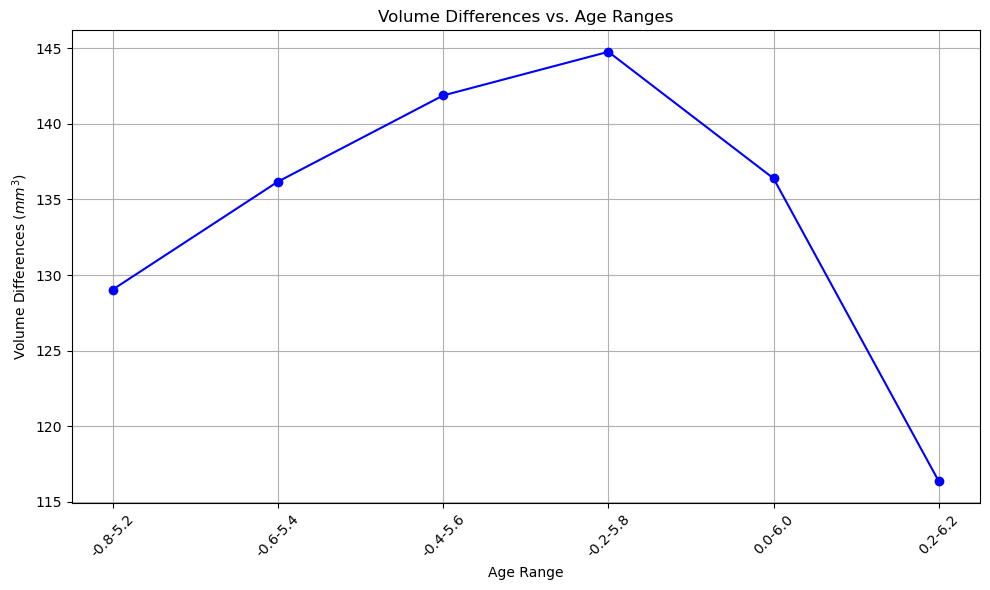

In [21]:
import matplotlib.pyplot as plt
# Create custom x-axis labels
age_ranges = [
    (34, 40),
    (40, 46),
    (46, 52),
    (52, 58),
    (58, 64),
    (64, 70),
]
# Create custom x-axis labels
x_axis_labels = [f'{start}-{end}' for start, end in age_ranges]

plt.figure(figsize=(10, 6))
plt.plot(volume_differences, marker='o', linestyle='-', color='b')
plt.title('Volume Differences vs. Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Volume Differences ($mm^3$)')
plt.xticks(range(len(z1_ranges)), x_axis_labels, rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
for i in range(2):
    mp.plot(verts_all[i], faces_all[i], c=np.array(white_color))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.004293…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002791…

In [ ]:
# Define file paths for saving vertices and faces
vertices_file = os.path.join(output_dir,"mesh_vertices.npy")
faces_file = os.path.join(output_dir,"mesh_faces.npy")


# Save vertices and faces to separate .npy files
np.save(vertices_file, verts_all)
np.save(faces_file, faces_all)

In [ ]:
# Calculate the distances between corresponding vertices
distances = np.linalg.norm(verts_all[1] - verts_all[0], axis=1)

# Create Open3D TriangleMesh objects
mesh1 = o3d.geometry.TriangleMesh()
mesh1.vertices = o3d.utility.Vector3dVector(verts_all[1])
mesh1.compute_vertex_normals()

mesh2 = o3d.geometry.TriangleMesh()
mesh2.vertices = o3d.utility.Vector3dVector(verts_all[0])
mesh2.compute_vertex_normals()

# Create a color mapping based on distances
# You can adjust the color thresholds as needed
color_map = o3d.visualization.draw_plotly([mesh1, mesh2])

# Normalize distances to the range [0, 1] for colormap mapping
normalized_distances = (distances - distances.min()) / (distances.max() - distances.min())

# Map distances to colors using the colormap
colors = np.asarray(color_map(normalized_distances))[:, :3]  # Extract RGB values

# Set the base color of mesh2 to white (or any other base color)
mesh2.paint_uniform_color([1, 1, 1])

# Assign the calculated colors to the faces of mesh2
mesh2.vertex_colors = o3d.utility.Vector3dVector(colors)

# Visualize both meshes
o3d.visualization.draw_plotly([mesh1, mesh2])

In [ ]:

# Calculate distance between meshes and create color-coded plots
z[1] = 0.2  # Set a specific value for z[1]
distances = np.zeros((len(np.arange(-1, 1.2, 0.2)), len([-1, 1])))
for i, z0_value in enumerate([-1, 1]):
    for j, z1_value in enumerate(np.arange(-1, 1.2, 0.2)):
        visualize_and_save(z0_value, z1_value)
        mesh1 = o3d.geometry.TriangleMesh.create_from_points(verts)
        mesh2 = o3d.geometry.TriangleMesh.create_from_points(verts)
        distances[j, i] = calculate_distance(mesh1, mesh2)

# Save distances as a color-coded plot
import matplotlib.pyplot as plt
plt.imshow(distances, cmap='viridis', origin='lower', extent=[-1, 1, -1, 1])
plt.colorbar(label='Distance')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.title('Distance Heatmap')
plt.savefig(os.path.join(output_dir, 'distance_heatmap.png'))


In [ ]:
np.interp(0.77, [0,1], [1,-1])

In [ ]:
np.interp(0.31, [0,1], [1,-1])